# Task 5: Results Analysis
## Random, ES, and GA Agents Performance Comparison

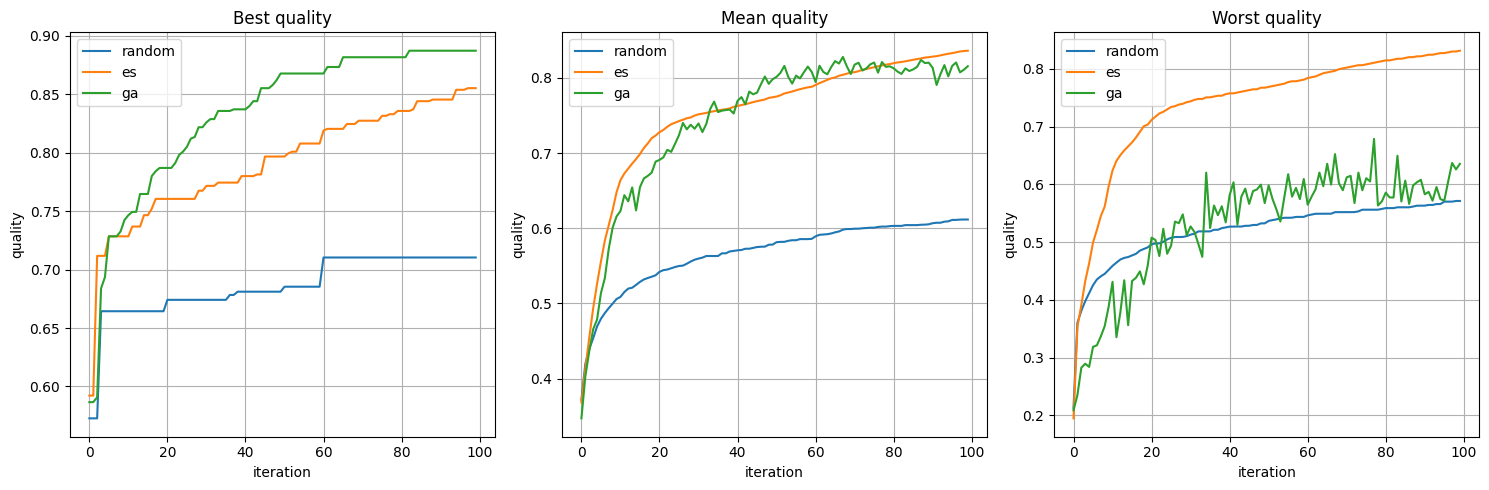

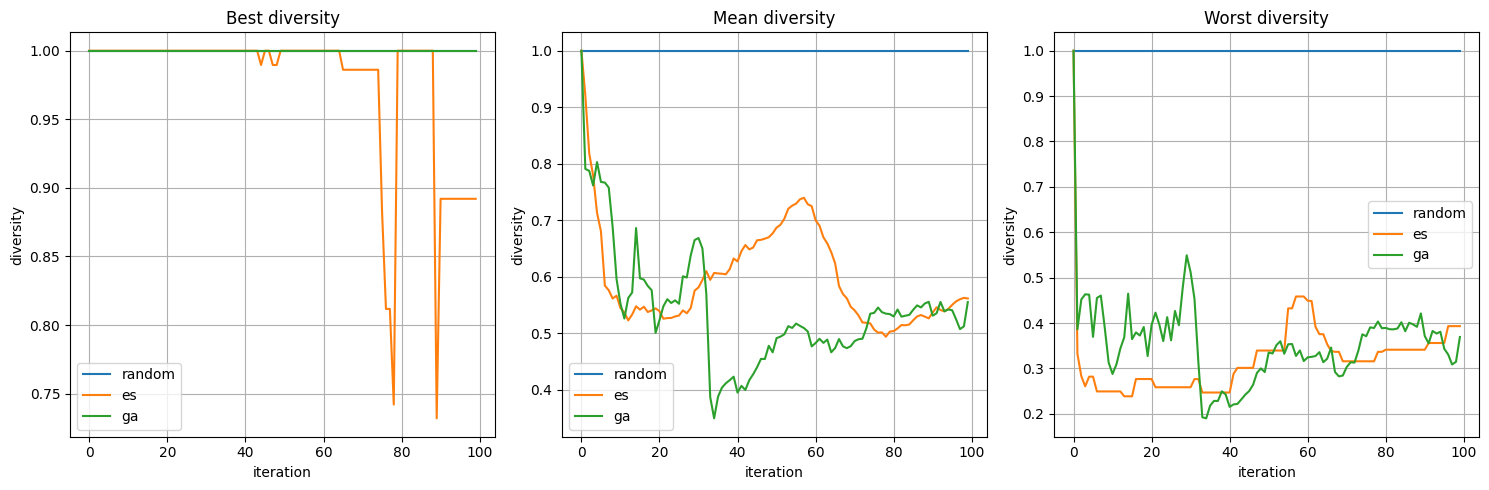

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

def load_iteration_param(base_folder, iteration, param = "quality"):
    iter_folder = os.path.join(base_folder, f'iter_{iteration}')
    qualities = []

    if not os.path.exists(iter_folder):
        return None

    for filename in os.listdir(iter_folder):
        if filename.endswith('.json'):
            filepath = os.path.join(iter_folder, filename)
            with open(filepath, 'r') as f:
                data = json.load(f)
                qualities.append(data[param])

    return qualities

def compare_iterations(parent_folders, max_iterations=100, param="quality"):
    results = {folder: {'mean': [], 'best': [], 'worst': []} for folder in parent_folders}

    for folder in parent_folders:
        for iteration in range(max_iterations):
            qualities = load_iteration_param(folder, iteration, param)

            if qualities is None or len(qualities) == 0:
                break

            results[folder]['mean'].append(sum(qualities) / len(qualities))
            results[folder]['best'].append(max(qualities))
            results[folder]['worst'].append(min(qualities))

    return results

def plot_comparison(results, title="quality"):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for metric, ax in zip(['best', 'mean', 'worst'], axes):
        for folder, data in results.items():
            ax.plot(data[metric], label=folder)

        ax.set_xlabel('iteration')
        ax.set_ylabel(title)
        ax.set_title(f'{metric.capitalize()} {title}')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

results_quality = compare_iterations(['random', 'es', 'ga'])
results_diversity = compare_iterations(['random', 'es', 'ga'], param="diversity")
plot_comparison(results_quality)
plot_comparison(results_diversity, "diversity")

## Binary space partitionong (BSP) Analysis
Binary space partitioning results for different depths. The higher depth value, the more rooms are created.

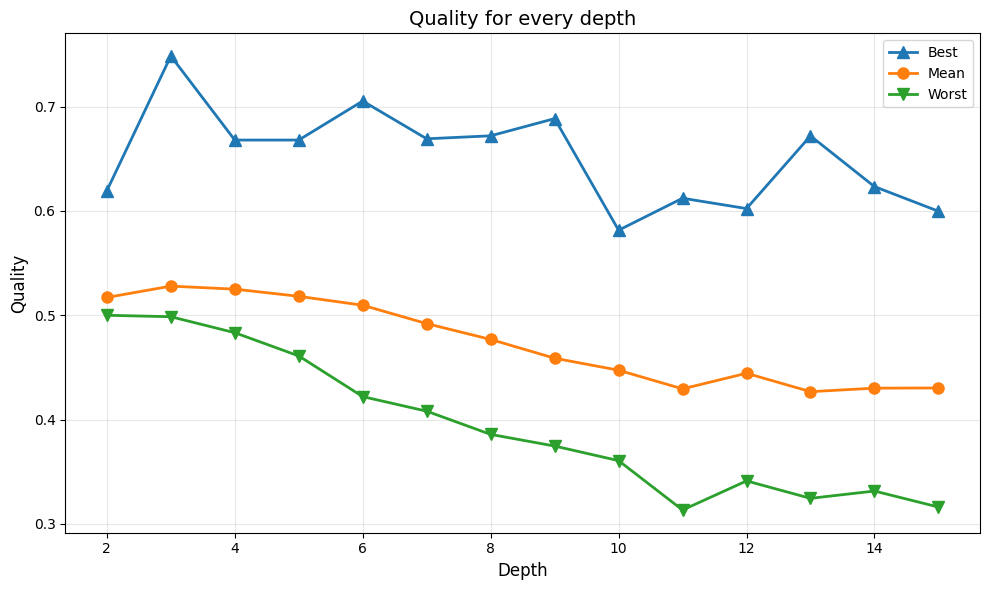

In [3]:
import matplotlib.pyplot as plt
import numpy as np

bsp_results = {}
bsp_folder = "binary_space_partitioning"

for filename in os.listdir(bsp_folder):
    if filename.startswith("bsp_") and filename.endswith(".json"):
        filepath = os.path.join(bsp_folder, filename)
        with open(filepath, 'r') as f:
            data = json.load(f)
            depth = data['depth']
            quality = data['quality']

            if depth not in bsp_results:
                bsp_results[depth] = []
            bsp_results[depth].append(quality)
depths = sorted(bsp_results.keys())
bests = [np.max(bsp_results[d]) for d in depths]
means = [np.mean(bsp_results[d]) for d in depths]
worsts = [np.min(bsp_results[d]) for d in depths]

plt.figure(figsize=(10, 6))
plt.plot(depths, bests, marker='^', label='Best', linewidth=2, markersize=8)
plt.plot(depths, means, marker='o', label='Mean', linewidth=2, markersize=8)
plt.plot(depths, worsts, marker='v', label='Worst', linewidth=2, markersize=8)

plt.xlabel('Depth', fontsize=12)
plt.ylabel('Quality', fontsize=12)
plt.title('Quality for every depth', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Agent-Based Generation Heatmap
In every step, agent have defined probability of turning and creating a room. This section analyses how these probabilities affect the final level quality.

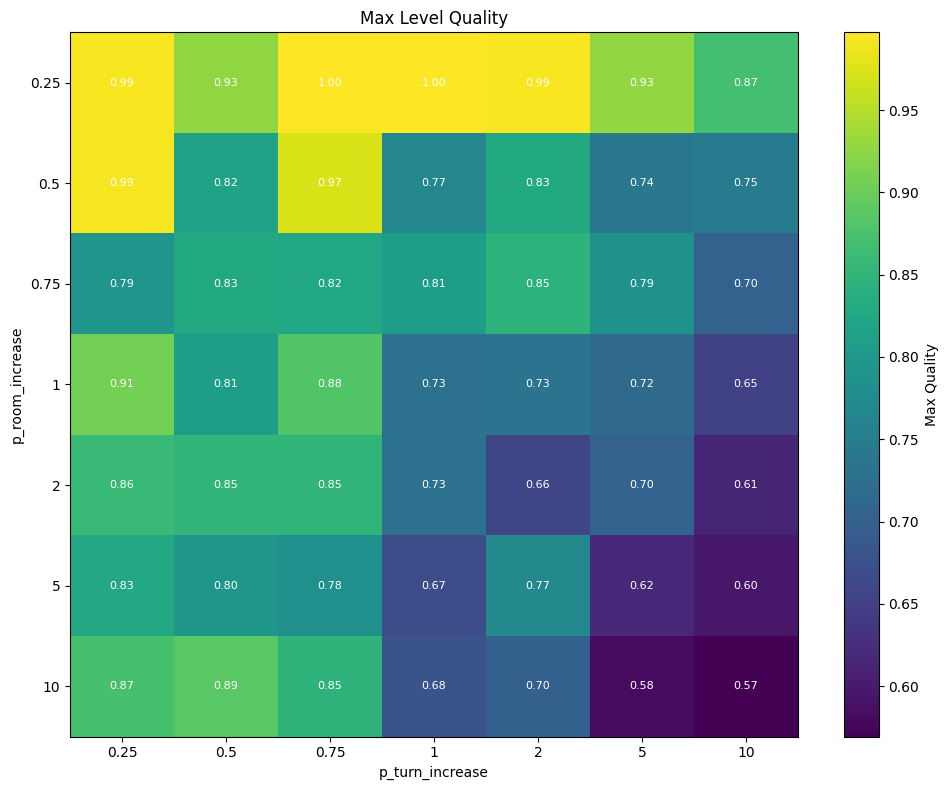

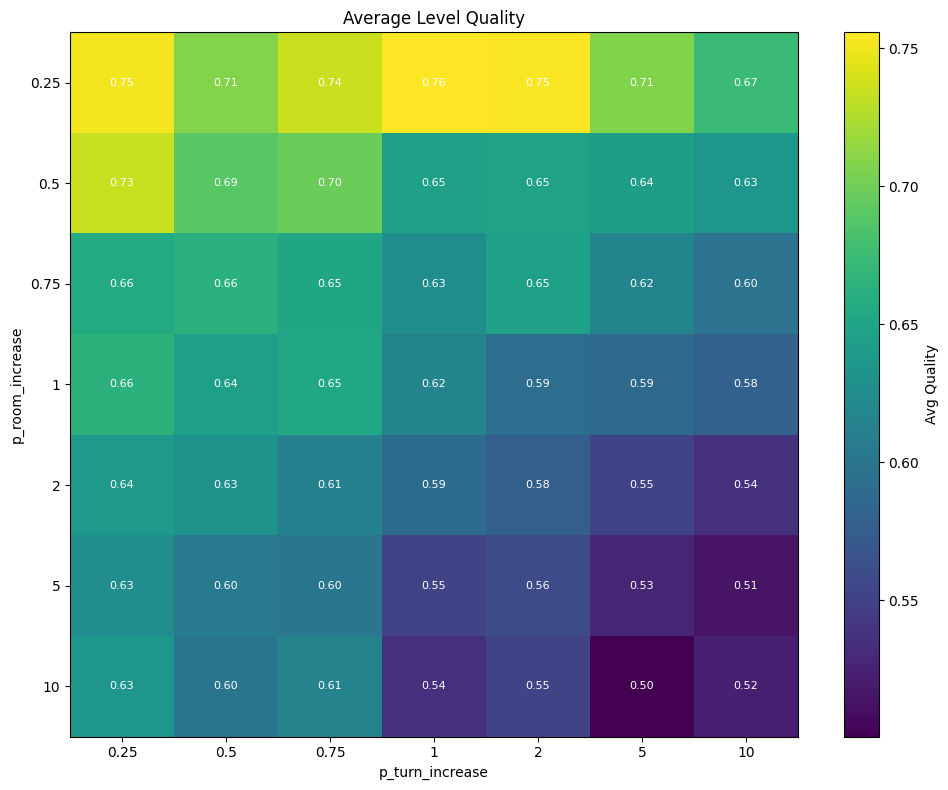

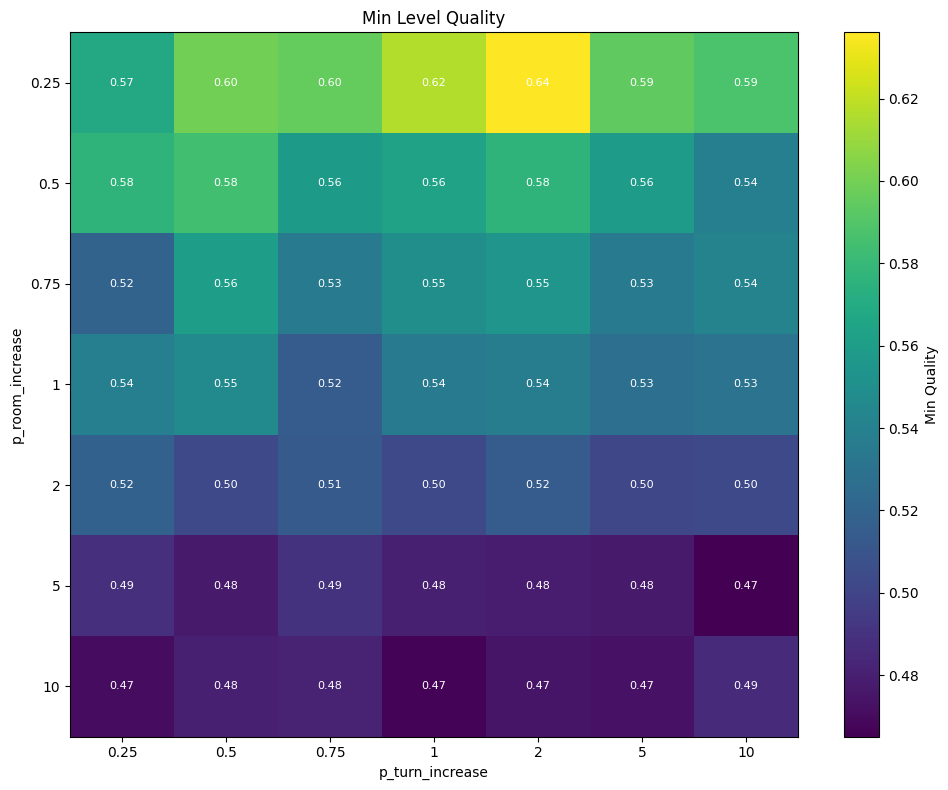

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os

abg_folder = "agent_based_generation"
abg_data = []

for filename in os.listdir(abg_folder):
    if filename.startswith("abg_") and filename.endswith(".json"):
        filepath = os.path.join(abg_folder, filename)
        with open(filepath, 'r') as f:
            data = json.load(f)
            abg_data.append({
                'p_turn': data['p_turn_increase'],
                'p_room': data['p_room_increase'],
                'quality': data['quality']
            })

p_turns = sorted(set(d['p_turn'] for d in abg_data))
p_rooms = sorted(set(d['p_room'] for d in abg_data))

def create_heatmap(data_matrix, turn_ps, room_ps, title, value_label, vmin=None, vmax=None):
    plt.figure(figsize=(10, 8))

    im = plt.imshow(data_matrix, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)

    plt.colorbar(im, label=value_label)
    plt.xlabel('p_turn_increase')
    plt.ylabel('p_room_increase')
    plt.title(title)

    plt.xticks(range(len(turn_ps)), turn_ps)
    plt.yticks(range(len(room_ps)), room_ps)

    for i in range(len(room_ps)):
        for j in range(len(turn_ps)):
            text = plt.text(j, i, f'{data_matrix[i, j]:.2f}',
                          ha="center", va="center", color="white", fontsize=8)

    plt.tight_layout()
    plt.show()

quality_matrix = np.zeros((len(p_rooms), len(p_turns)))
min_quality_matrix = np.full((len(p_rooms), len(p_turns)), np.inf)
max_quality_matrix = np.full((len(p_rooms), len(p_turns)), -np.inf)
count_matrix = np.zeros((len(p_rooms), len(p_turns)))

for entry in abg_data:
    i = p_rooms.index(entry['p_room'])
    j = p_turns.index(entry['p_turn'])

    quality = entry['quality']
    quality_matrix[i, j] += quality
    count_matrix[i, j] += 1
    min_quality_matrix[i, j] = min(min_quality_matrix[i, j], quality)
    max_quality_matrix[i, j] = max(max_quality_matrix[i, j], quality)

quality_matrix = quality_matrix / np.maximum(count_matrix, 1)

create_heatmap(max_quality_matrix, p_turns, p_rooms,
               'Max Level Quality', 'Max Quality')

create_heatmap(quality_matrix, p_turns, p_rooms,
               'Average Level Quality', 'Avg Quality')

create_heatmap(min_quality_matrix, p_turns, p_rooms,
               'Min Level Quality', 'Min Quality')
